Kaggle Competition: BBC News Classification 

Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
We will first define a class to handle csv files, implementing EDA and cleaning process.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

class DataAnalyzer:
    def __init__(self):
        self.train_data = None
        self.test_data = None


    def load_data(self, file_path, is_train=True):
        """
        Load data from a CSV file.
        
        :param file_path: str, path to the CSV file
        :param is_train: bool, True if loading training data, False otherwise
        :return: DataFrame, loaded data
        """
        data = pd.read_csv(file_path)
        if is_train:
            self.train_data = data
        else:
            self.test_data = data
        return data
    
    @staticmethod
    def show_basic_info(data):
        """
        Display basic information and statistics of the dataset.
        
        :param data: DataFrame, input data
        """
        print("Basic Information:")
        print(data.info())
        print("\nStatistical Summary:")
        print(data.describe())
        print("\nCategory Distribution:")
        print(data['Category'].value_counts())
    
    @staticmethod
    def plot_category_distribution(data):
        """
        Plot the distribution of article categories.
        
        :param data: DataFrame, input data
        """
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Category', data=data, order=data['Category'].value_counts().index)
        plt.title('Category Distribution')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        
    @staticmethod
    def plot_text_length_distribution(data, target_column='Text'):
        """
        Plot the distribution of text lengths in the dataset.
        :param target_column: targeted column name
        :param data: DataFrame, input data
        """
        data['Text_Length'] = data[target_column].apply(len)
        plt.figure(figsize=(10, 6))
        sns.histplot(data['Text_Length'], bins=50, kde=True)
        plt.title('Text Length Distribution')
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
        plt.show()

    @staticmethod
    def show_word_frequencies(data, target_column='Text'):
        """
        Display the most common words and generate a word cloud.
        :param target_column: targeted column name
        :param data: DataFrame, input data
        """
        all_text = " ".join(data[target_column])
        words = all_text.split()
        word_counts = Counter(words)
        common_words = word_counts.most_common(20)
        
        print("\nMost Common 20 Words:")
        for word, count in common_words:
            print(f"{word}: {count}")

        wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud')
        plt.axis('off')
        plt.show()

    def perform_eda(self, data, target_column='Text'):
        """
        Perform exploratory data analysis by calling individual EDA functions.
        :param target_column: targeted column name
        :param data: DataFrame, input data
        """
        self.show_basic_info(data)
        self.plot_category_distribution(data)
        self.plot_text_length_distribution(data, target_column=target_column)
        self.show_word_frequencies(data, target_column=target_column)
        

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None

Statistical Summary:
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


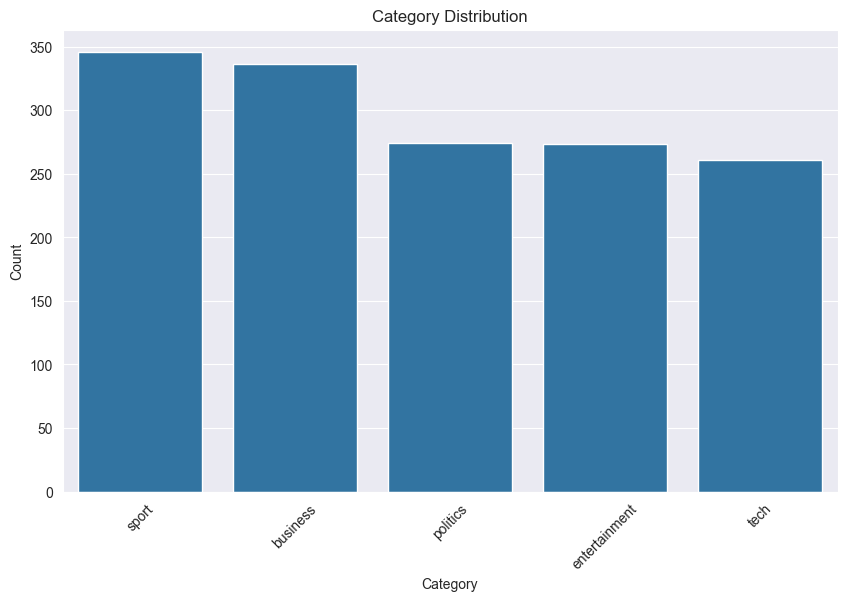

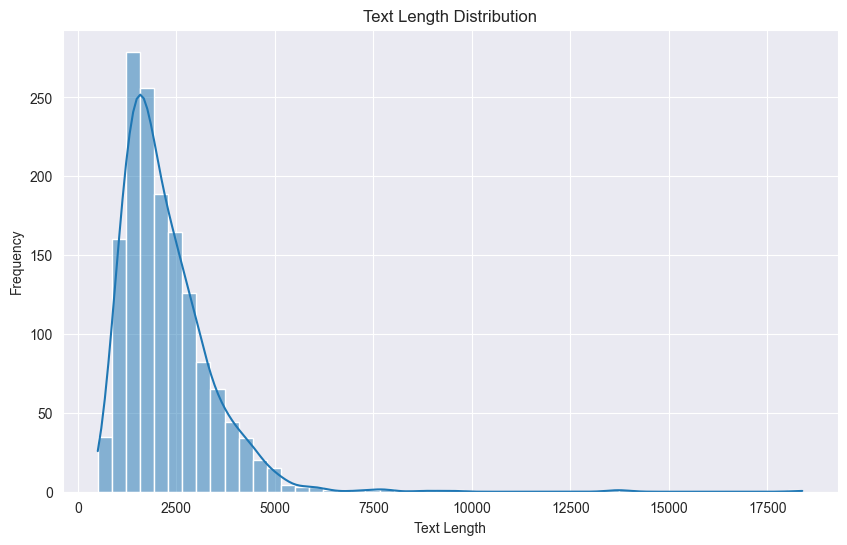


Most Common 20 Words:
the: 34992
to: 16568
of: 12970
and: 12366
a: 12102
in: 11696
s: 5899
for: 5773
is: 5478
that: 5207
it: 5000
on: 4991
was: 4019
he: 3866
be: 3803
with: 3482
said: 3401
has: 3250
as: 3245
have: 3133


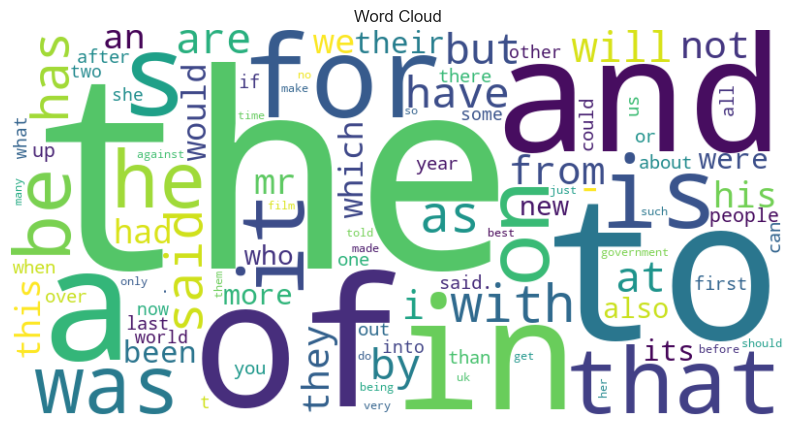

In [18]:
analyzer = DataAnalyzer()
train_data = analyzer.load_data('data/BBC News Train.csv', is_train=True)
test_data = analyzer.load_data('data/BBC News Test.csv', is_train=False)
analyzer.perform_eda(train_data)

According to the EDA above, we learn that each category has close weight to the whole data, and we learn that the text length does not distribute evenly, most of which has 1000-5000.
Besides, from the wordcloud plot, we learn that the most frequent words in English are empty words, such as 'the', 'is', 'and'. This kind of words, is called 'stop words', which means noise in text processing. Hence, removing such stop words is crucial in further implementation.
Furthermore, in English, a word may have multiple forms but with the same 'stem', which means the origin of the word. The application of lemmatization is implemented to transform word formation into the same word.


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

class DataCleaner(DataAnalyzer):
    def __init__(self, analyzer):
        super().__init__()
        self.__dict__.update(analyzer.__dict__)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    @staticmethod
    def clean_data(data):
        """
        Clean the data by removing duplicates and missing values.
        
        :param data: DataFrame, input data
        :return: DataFrame, cleaned data
        """
        data_cleaned = data.dropna().drop_duplicates()
        return data_cleaned
    
    def preprocess_text(self, text):
        """
        Preprocess the text by removing stop words and applying lemmatization.
        
        :param text: str, input text
        :return: str, processed text
        """
        tokens = text.split()
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token.lower() not in self.stop_words]
        return " ".join(tokens)
    
    def preprocess_texts(self, data):
        """
        Apply text preprocessing to each text in the DataFrame.
        
        :param data: DataFrame, input data
        :return: DataFrame, data with processed texts
        """
        data['Processed_Text'] = data['Text'].apply(self.preprocess_text)
        return data
        
    def data_process(self):
        """
        Perform data cleaning and text preprocessing.
        """
        # Clean the data
        self.train_data = self.clean_data(self.train_data)
        # Preprocess the texts
        self.train_data = self.preprocess_texts(self.train_data)
        if self.test_data is not None:
            self.test_data = self.clean_data(self.test_data)
            self.test_data = self.preprocess_texts(self.test_data)
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Text_Length     1490 non-null   int64 
 4   Processed_Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
None

Statistical Summary:
         ArticleId   Text_Length
count  1490.000000   1490.000000
mean   1119.696644   2233.461745
std     641.826283   1205.153358
min       2.000000    501.000000
25%     565.250000   1453.000000
50%    1112.500000   1961.000000
75%    1680.750000   2751.250000
max    2224.000000  18387.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


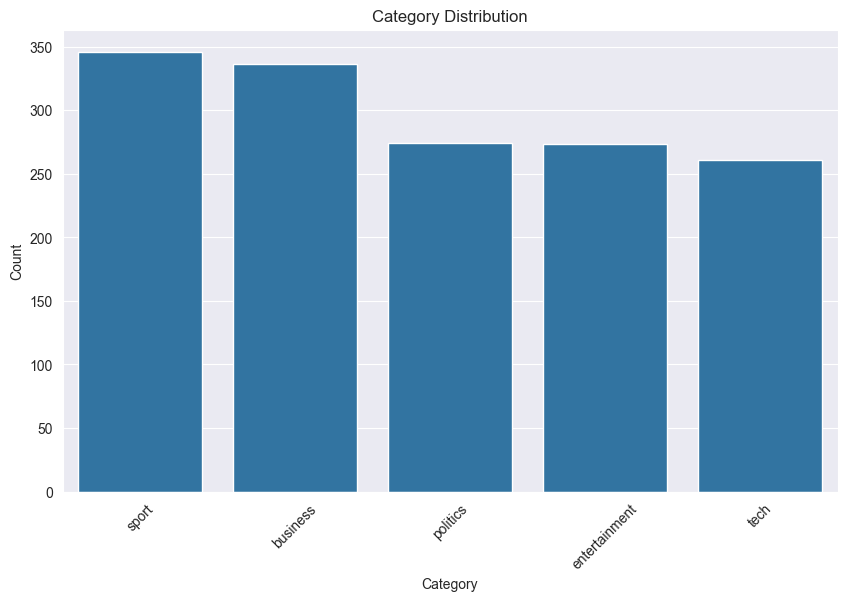

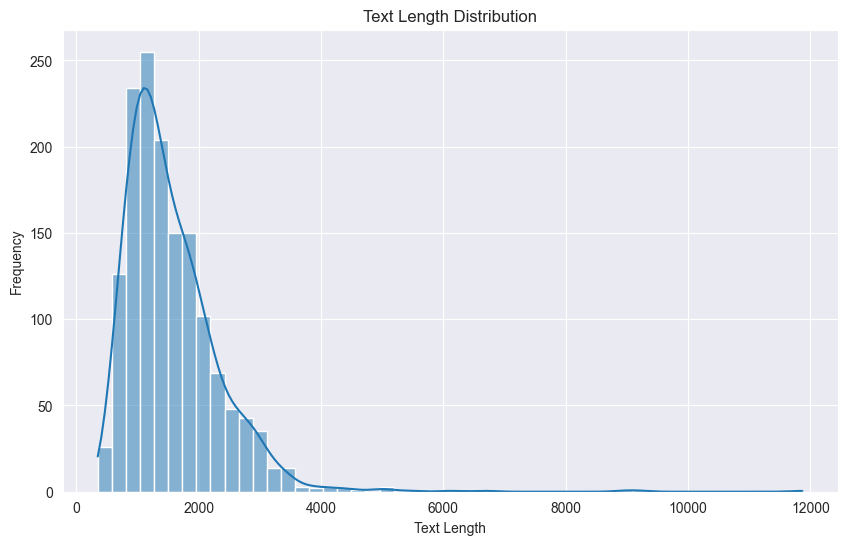


Most Common 20 Words:
said: 3401
-: 2125
mr: 2002
would: 1710
year: 1425
also: 1424
new: 1329
people: 1278
one: 1151
u: 1139
could: 1031
said.: 987
first: 890
last: 883
two: 801
game: 799
time: 795
.: 790
say: 747
world: 730


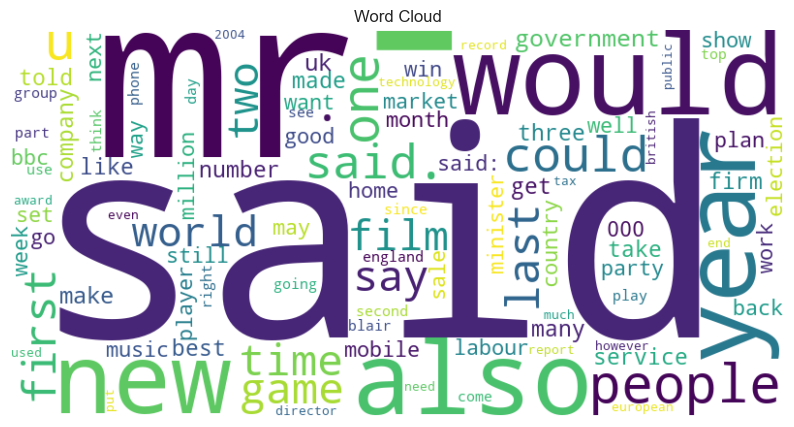

In [20]:
cleaner = DataCleaner(analyzer)
cleaner.data_process()
cleaner.perform_eda(cleaner.train_data, target_column='Processed_Text')

Based on the latest processing outcome, I realize that there are many punctuations and meaningless words (e.g. 'make') in the most frequent words, which require further filter. Besides, I notice that maybe upper and lower first letter should be unified as the same formation. I will update the preprocess_text() method of class.

In [37]:
# redefine the class DataCleaner
import string
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

class DataCleaner(DataAnalyzer):
    def __init__(self, analyzer):
        super().__init__()
        self.__dict__.update(analyzer.__dict__)
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    @staticmethod
    def clean_data(data):
        """
        Clean the data by removing duplicates and missing values.
        
        :param data: DataFrame, input data
        :return: DataFrame, cleaned data
        """
        data_cleaned = data.dropna().drop_duplicates()
        return data_cleaned
    
    def preprocess_text(self, text):
        """
        Preprocess the text by converting to lowercase, removing stop words, punctuation, high-frequency non-informative words, and applying lemmatization.
        
        :param text: str, input text
        :return: str, processed text
        """
        high_freq_words = {'said', 'mr', 'also', 'would', 'one', 'could', 'u', 'say', 'year', 'you', 'go', 'come', 'last', 'first', 'time', 'make', 'use', 'take'}
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words]
        tokens = [word for word in tokens if word not in high_freq_words]
        pos_tags = pos_tag(tokens)
        tokens = [self.lemmatizer.lemmatize(token, self.get_wordnet_pos(tag)) for token, tag in pos_tags]
        return " ".join(tokens)
    
    @staticmethod
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
    def preprocess_texts(self, data):
        """
        Apply text preprocessing to each text in the DataFrame.
        
        :param data: DataFrame, input data
        :return: DataFrame, data with processed texts
        """
        data['Processed_Text'] = data['Text'].apply(self.preprocess_text)
        return data
        
    def data_process(self):
        """
        Perform data cleaning and text preprocessing.
        """
        # Clean the data
        self.train_data = self.clean_data(self.train_data)
        # Preprocess the texts
        self.train_data = self.preprocess_texts(self.train_data)
        if self.test_data is not None:
            self.test_data = self.clean_data(self.test_data)
            self.test_data = self.preprocess_texts(self.test_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Text_Length     1490 non-null   int64 
 4   Processed_Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
None

Statistical Summary:
         ArticleId   Text_Length
count  1490.000000   1490.000000
mean   1119.696644   2233.461745
std     641.826283   1205.153358
min       2.000000    501.000000
25%     565.250000   1453.000000
50%    1112.500000   1961.000000
75%    1680.750000   2751.250000
max    2224.000000  18387.000000

Category Distribution:
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


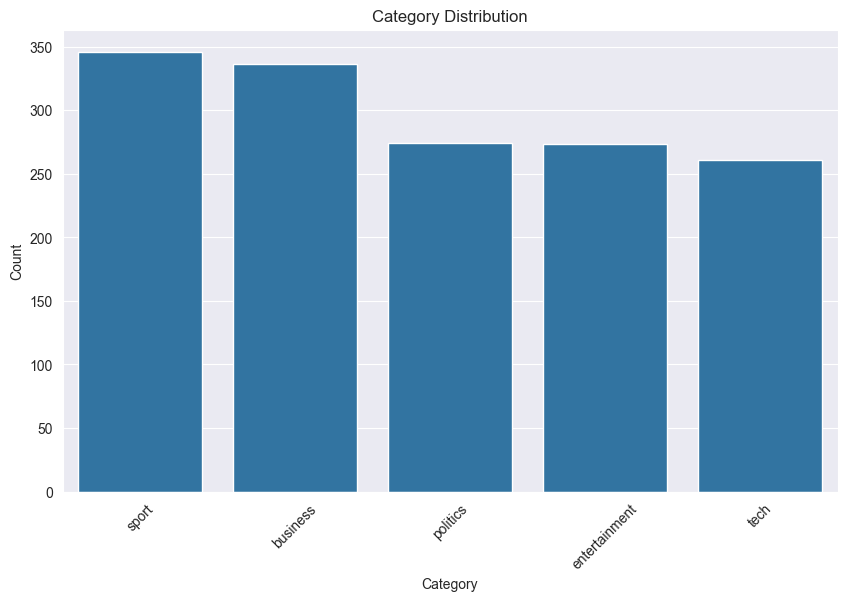

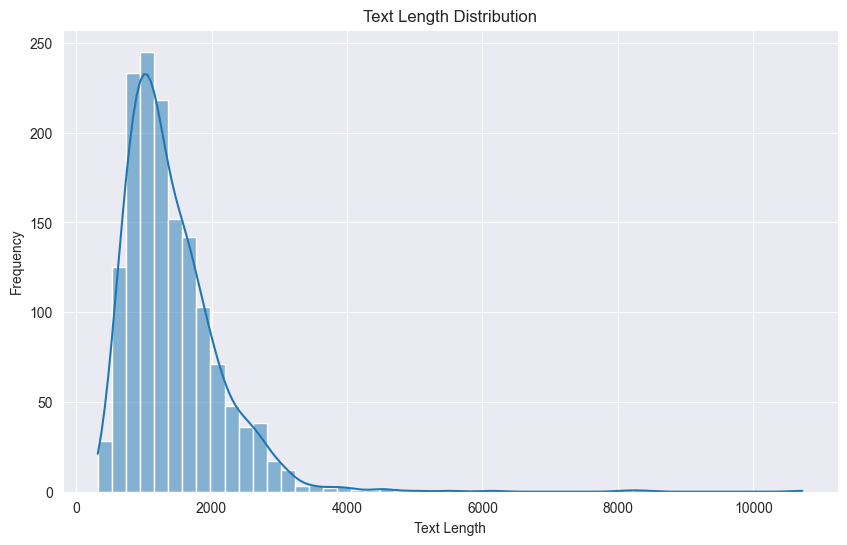


Most Common 20 Words:
new: 1347
people: 1323
u: 1226
game: 1031
get: 1015
make: 851
two: 816
world: 809
film: 808
government: 771
show: 760
uk: 757
go: 752
play: 735
work: 717
company: 682
take: 682
firm: 676
say: 656
give: 654


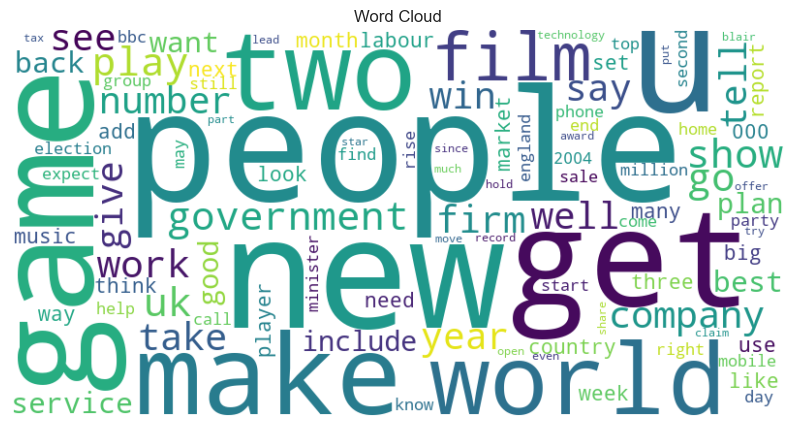

In [38]:
cleaner = DataCleaner(analyzer)
cleaner.data_process()
cleaner.perform_eda(cleaner.train_data, target_column='Processed_Text')